# 문제7: 상관 관계 파악

## 수행목표

- 영화 장르간 상관 관계를 확인하고 시각화한다.

## 수행단계

- 상관 관계 탐색
  - 영화의 장르간 상관 관계를 파악하라. (Heatmap) (힌트, pivot)

## 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import ipywidgets as widgets
from IPython.display import display, clear_output

## 데이터셋 확인

In [2]:
KMRD_PATH = "kmrd-small"

### KMRD (Korean Movie Recommender system Dataset)

In [3]:
kmrd_castings_path = os.path.join(KMRD_PATH, "castings.csv")
kmrd_countries_path = os.path.join(KMRD_PATH, "countries.csv")
kmrd_genres_path   = os.path.join(KMRD_PATH, "genres.csv")
kmrd_movies_path   = os.path.join(KMRD_PATH, "movies.txt")
kmrd_peoples_path  = os.path.join(KMRD_PATH, "peoples.txt")
kmrd_rates_path    = os.path.join(KMRD_PATH, "rates.csv")

In [4]:

# Load CSV files
df_kmrd_castings  = pd.read_csv(kmrd_castings_path)
df_kmrd_countries = pd.read_csv(kmrd_countries_path)
df_kmrd_genres    = pd.read_csv(kmrd_genres_path)
df_kmrd_rates     = pd.read_csv(kmrd_rates_path)

# Load txt files
df_kmrd_peoples   = pd.read_csv(kmrd_peoples_path, sep='\t', engine='python')

In [5]:
missing_movie_ids = set();

def extract_eng_year(s, year_kor=None):
    """
    If s matches the pattern: "Something , 4-digit-year"
    return (english_title, year_original_as_float).
    Otherwise, return (s, None).
    """
    pattern = r"^(.*?)\s*,\s*(\d{4})$"
    match = re.match(pattern, s.strip())
    if match:
        eng = match.group(1).strip()
        yr  = float(match.group(2))
        return eng, yr
    else:
        if year_kor and year_kor.isnumeric() and s.strip() == year_kor:
            return None, float(s.strip())
        return s.strip(), None

def parse_movies_txt(filepath):
    """
    Reads the movies.txt line by line, ignoring empty lines,
    and splits into columns: 
        movie (str), 
        title_kor (str), 
        title_eng (str), 
        year_original (float), 
        year_korea (float), 
        grade (str)
    
    year_original and year_korea might be NaN if not found.
    We ONLY drop lines if BOTH the Korean title AND English title are missing.
    """
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        f.readline()
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split('\t')
            if len(parts) < 2:
                missing_movie_ids.add(parts[0])
                continue
            
            movie_id    = None
            title_kor   = None
            title_eng   = None
            year_original   = None
            year_korea  = None
            grade       = None
            
            movie_id  = parts[0].strip() if len(parts) >= 1 else None
            title_kor = parts[1].strip() if len(parts) >= 2 else None

            extra_cols = parts[2:]
            

            # Possible cases:
            #  - 0 extra_cols => [movie_id, title_kor]
            #  - 1 extra_cols => [movie_id, title_kor, title_eng+year]
            #  - 2 extra_cols => [movie_id, title_kor, title_eng+year, year_korea]
            #  - 3 extra_cols => [movie_id, title_kor, title_eng+year, year_korea, grade]
            #                 => [movie_id, title_kor, year, year_korea, grade]
            #  - 4 extra_cols => [movie_id, title_kor, title_eng+year, year_korea, grade, ???]
            
            if len(extra_cols) == 1:
                t_eng, y_original = extract_eng_year(extra_cols[0])
                title_eng   = t_eng
                year_original   = y_original
            elif len(extra_cols) == 2:
                t_eng, y_original = extract_eng_year(extra_cols[0])
                title_eng  = t_eng
                year_original  = y_original
                
                try:
                    year_korea = float(extra_cols[1])
                except ValueError:
                    grade = extra_cols[1].strip()
            elif len(extra_cols) == 3:
                t_eng, y_original = extract_eng_year(extra_cols[0], extra_cols[1])
                title_eng  = t_eng
                year_original  = y_original
                
                try:
                    year_korea = float(extra_cols[1])
                except ValueError:
                    if extra_cols[1].strip():
                        grade = extra_cols[1].strip()
                
                if grade is None:
                    grade = extra_cols[2].strip()
            else:
                if len(extra_cols) == 0:
                    pass
                else:
                    t_eng, y_original = extract_eng_year(extra_cols[0])
                    title_eng  = t_eng
                    year_original  = y_original
                    if len(extra_cols) >= 2:
                        try:
                            year_korea = float(extra_cols[1])
                        except ValueError:
                            grade = extra_cols[1].strip()
                    if len(extra_cols) >= 3 and grade is None:
                        grade = extra_cols[2].strip()
            
            records.append({
                "movie": movie_id if movie_id else None,
                "title_kor": title_kor if title_kor else None,
                "title_eng": title_eng if title_eng else None,
                "year_original": year_original,
                "year_korea": year_korea,
                "grade": grade if grade else None
            })
    
    df = pd.DataFrame(records)
    
    df = df[df['movie'].notna() & (df['movie'] != '')]
    
    mask_titles_missing = df['title_kor'].isna() & df['title_eng'].isna()
    df = df[~mask_titles_missing]
    
    return df

In [6]:
df_kmrd_movies = parse_movies_txt(kmrd_movies_path)
print(df_kmrd_movies.shape)
df_kmrd_movies.head(100)

(992, 6)


,movie,title_kor,title_eng,year_original,year_korea,grade
0,10001,시네마 천국,Cinema Paradiso,1988.0,2013.0,전체 관람가
1,10002,빽 투 더 퓨쳐,Back To The Future,1985.0,2015.0,12세 관람가
2,10003,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
3,10004,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
4,10005,스타워즈 에피소드 4 - 새로운 희망,Star Wars,1977.0,1997.0,PG
...,...,...,...,...,...,...
95,10096,고스트버스터즈 2,Ghostbusters II,1989.0,1990.0,PG
96,10097,굿모닝 베트남,"Good Morning, Vietnam",1987.0,NaN,15세 관람가
97,10098,자유의 댄스,Footloose,1984.0,NaN,PG
98,10099,남과 여,"Un Homme Et Une Femme , A Man And A Woman",1966.0,1979.0,15세 관람가


#### 데이터 조회 및 검사

##### Castings 정보

In [7]:
df_kmrd_castings.info()
df_kmrd_castings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9776 entries, 0 to 9775
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   movie    9776 non-null   int64
 1   people   9776 non-null   int64
 2   order    9776 non-null   int64
 3   leading  9776 non-null   int64
dtypes: int64(4)
memory usage: 305.6 KB


,movie,people,order,leading
0,10001,4374,1,1
1,10001,178,2,1
2,10001,3241,3,1
3,10001,47952,4,1
4,10001,47953,5,0


In [8]:
print("Unique values in KMRD Castings:")
print(df_kmrd_castings.nunique())

Unique values in KMRD Castings:
movie       988
people     6644
order       101
leading       2
dtype: int64


In [9]:
missing_movie_ids_casting = set(range(10001, 10999)) - set(df_kmrd_castings['movie'].unique())
print("Number of missing movie ids in castings:", len(missing_movie_ids_casting))
print("Missing movie ids:", missing_movie_ids_casting)

Number of missing movie ids in castings: 11
Missing movie ids: {10793, 10475, 10957, 10990, 10672, 10707, 10772, 10963, 10327, 10906, 10878}


##### Countries 정보

In [10]:
df_kmrd_countries.info()
df_kmrd_countries.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movie    1109 non-null   int64 
 1   country  1109 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


,movie,country
0,10001,이탈리아
1,10001,프랑스
2,10002,미국
3,10003,미국
4,10004,미국


In [11]:
print("Unique values in KMRD Countries:")
print(df_kmrd_countries.nunique())

Unique values in KMRD Countries:
movie      990
country     36
dtype: int64


In [12]:
df_kmrd_countries = df_kmrd_countries.dropna()
df_kmrd_countries = df_kmrd_countries.drop_duplicates()
print("KMRD Countries shape after dropping na values:", df_kmrd_countries.shape)

KMRD Countries shape after dropping na values: (1109, 2)


##### Genres 정보

In [13]:
df_kmrd_genres.info()
df_kmrd_genres.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025 entries, 0 to 2024
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   2025 non-null   int64 
 1   genre   2025 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.8+ KB


,movie,genre
0,10001,드라마
1,10001,멜로/로맨스
2,10002,SF
3,10002,코미디
4,10003,SF


In [14]:
print("Unique values in KMRD Genres:")
print(df_kmrd_genres.nunique())

Unique values in KMRD Genres:
movie    964
genre     20
dtype: int64


##### Movies 정보

In [15]:
df_kmrd_movies.info()
df_kmrd_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie          992 non-null    object 
 1   title_kor      992 non-null    object 
 2   title_eng      977 non-null    object 
 3   year_original  987 non-null    float64
 4   year_korea     609 non-null    float64
 5   grade          957 non-null    object 
dtypes: float64(2), object(4)
memory usage: 46.6+ KB


,movie,title_kor,title_eng,year_original,year_korea,grade
0,10001,시네마 천국,Cinema Paradiso,1988.0,2013.0,전체 관람가
1,10002,빽 투 더 퓨쳐,Back To The Future,1985.0,2015.0,12세 관람가
2,10003,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
3,10004,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
4,10005,스타워즈 에피소드 4 - 새로운 희망,Star Wars,1977.0,1997.0,PG


In [16]:
print("Unique values in KMRD Movies:")
print(df_kmrd_movies.nunique())

Unique values in KMRD Movies:
movie            992
title_kor        969
title_eng        957
year_original     79
year_korea        72
grade              9
dtype: int64


##### Peoples 정보

In [17]:
df_kmrd_peoples.info()
df_kmrd_peoples.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   people    7172 non-null   int64 
 1   korean    7172 non-null   object
 2   original  6305 non-null   object
dtypes: int64(1), object(2)
memory usage: 168.2+ KB


,people,korean,original
0,5,아담 볼드윈,Adam Baldwin
1,8,애드리안 라인,Adrian Lyne
2,9,에이단 퀸,Aidan Quinn
3,13,구로사와 아키라,Akira Kurosawa
4,15,알 파치노,Al Pacino


In [18]:
print("Unique values in KMRD Peoples:")
print(df_kmrd_peoples.nunique())

Unique values in KMRD Peoples:
people      7172
korean      7153
original    6299
dtype: int64


##### Ratings 정보

In [19]:
df_kmrd_rates.info()
df_kmrd_rates.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140710 entries, 0 to 140709
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   user    140710 non-null  int64
 1   movie   140710 non-null  int64
 2   rate    140710 non-null  int64
 3   time    140710 non-null  int64
dtypes: int64(4)
memory usage: 4.3 MB


,user,movie,rate,time
0,0,10003,7,1494128040
1,0,10004,7,1467529800
2,0,10018,9,1513344120
3,0,10021,9,1424497980
4,0,10022,7,1427627340


In [20]:
print("Unique values in KMRD Rates:")
df_kmrd_rates.nunique()

Unique values in KMRD Rates:


user      52028
movie       600
rate         10
time     136972
dtype: int64

## 데이터 결측치 및 이상치 확인

#### 결측치 확인

- movies.txt 의 경우 이미 결측치가 제거된 상태임

In [21]:
print("KMRD Castings shape:", df_kmrd_castings.shape)
print("KMRD Countries shape:", df_kmrd_countries.shape)
print("KMRD Genres shape:", df_kmrd_genres.shape)
print("KMRD Movies shape:", df_kmrd_movies.shape)
print("KMRD Peoples shape:", df_kmrd_peoples.shape)
print("KMRD Rates shape:", df_kmrd_rates.shape)

KMRD Castings shape: (9776, 4)
KMRD Countries shape: (1109, 2)
KMRD Genres shape: (2025, 2)
KMRD Movies shape: (992, 6)
KMRD Peoples shape: (7172, 3)
KMRD Rates shape: (140710, 4)


In [22]:
df_kmrd_castings = df_kmrd_castings.dropna()
df_kmrd_castings = df_kmrd_castings.drop_duplicates()
print("KMRD Castings shape after dropping na values:", df_kmrd_castings.shape)

KMRD Castings shape after dropping na values: (9776, 4)


In [23]:
df_kmrd_countries = df_kmrd_countries.dropna()
df_kmrd_countries = df_kmrd_countries.drop_duplicates()
print("KMRD Countries shape after dropping na values:", df_kmrd_countries.shape)

KMRD Countries shape after dropping na values: (1109, 2)


In [24]:
df_kmrd_genres = df_kmrd_genres.dropna()
df_kmrd_genres = df_kmrd_genres.drop_duplicates()
print("KMRD Genres shape after dropping na values:", df_kmrd_genres.shape)

KMRD Genres shape after dropping na values: (2025, 2)


In [25]:
df_kmrd_peoples = df_kmrd_peoples.dropna()
df_kmrd_peoples = df_kmrd_peoples.drop_duplicates()
print("KMRD Peoples shape after dropping na values:", df_kmrd_peoples.shape)

KMRD Peoples shape after dropping na values: (6305, 3)


In [26]:
df_kmrd_rates = df_kmrd_rates.dropna()
df_kmrd_rates = df_kmrd_rates.drop_duplicates()
print("KMRD Ratings shape after dropping na values:", df_kmrd_rates.shape)

KMRD Ratings shape after dropping na values: (140678, 4)


#### 이상치 확인

##### Ratings 정보

In [27]:
print(df_kmrd_rates['rate'].describe())

out_of_range = df_kmrd_rates[ (df_kmrd_rates['rate'] < 1) | (df_kmrd_rates['rate'] > 10) ]
print("Out-of-range rating rows:", len(out_of_range))

df_kmrd_rates['zscore_rate'] = stats.zscore(df_kmrd_rates['rate'].astype(float))
outliers = df_kmrd_rates[ df_kmrd_rates['zscore_rate'].abs() > 3 ]
print("Potential outliers (|z|>3) in rating:", len(outliers))

df_kmrd_rates_zscore = df_kmrd_rates[ df_kmrd_rates['zscore_rate'].abs() <= 3 ]
print("KMRD Ratings shape after dropping invalid ratings:", df_kmrd_rates_zscore.shape)

user_counts = df_kmrd_rates_zscore['user'].value_counts()
user_counts = user_counts[user_counts >= 30]
df_kmrd_rates_rating_count = df_kmrd_rates_zscore[df_kmrd_rates_zscore['user'].isin(user_counts.index)]
print("KMRD Ratings shape after dropping users with less than 30 ratings:", df_kmrd_rates_rating_count.shape)

count_by_movie = df_kmrd_rates.groupby('movie')['rate'].count().reset_index(name='rating_count')
df_kmrd_rates_movie_count = df_kmrd_rates.merge(count_by_movie, on='movie', how='left', validate='m:1')
threshold = 30
df_filtered = df_kmrd_rates_movie_count[df_kmrd_rates_movie_count['rating_count'] >= threshold].copy()
print("Total movies before filtering:", df_kmrd_rates['movie'].nunique())
print("Total movies after filtering (>=30 ratings):", df_filtered['movie'].nunique())


df_kmrd_rates = df_kmrd_rates.drop('zscore_rate', axis=1)

count    140678.000000
mean          8.953433
std           2.105626
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rate, dtype: float64
Out-of-range rating rows: 0
Potential outliers (|z|>3) in rating: 5964
KMRD Ratings shape after dropping invalid ratings: (134714, 5)
KMRD Ratings shape after dropping users with less than 30 ratings: (29502, 5)
Total movies before filtering: 600
Total movies after filtering (>=30 ratings): 409


## 데이터 시각화

In [28]:
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [29]:
df_user_rate_w_genre = pd.merge(df_kmrd_rates_movie_count, df_kmrd_genres, on='movie', how='inner', validate='m:m')

df_user_rate_w_genre_avg = df_user_rate_w_genre.groupby(['user', 'genre'])['rate'].mean().reset_index()
print("Average rating by genre:")
print(df_user_rate_w_genre_avg.head(100))

Average rating by genre:
    user genre       rate
0      0    SF   7.818182
1      0    가족   7.333333
2      0    공포   9.000000
3      0   느와르   8.500000
4      0   드라마   7.266667
..   ...   ...        ...
95     9    액션  10.000000
96     9    전쟁  10.000000
97     9   코미디  10.000000
98     9   판타지  10.000000
99    10    SF  10.000000

[100 rows x 3 columns]


In [30]:

user_genre_matrix = df_user_rate_w_genre_avg.pivot(index='user', columns='genre', values='rate')

print("User–Genre Matrix (rows=user, cols=genre, values=avg rating):")
print(user_genre_matrix.head(10))

User–Genre Matrix (rows=user, cols=genre, values=avg rating):
genre         SF         가족         공포   느와르  다큐멘터리        드라마     멜로/로맨스  \
user                                                                        
0       7.818182   7.333333   9.000000   8.5    NaN   7.266667   7.315789   
1            NaN        NaN        NaN   NaN    NaN   9.000000        NaN   
2       7.250000        NaN   7.800000   NaN    NaN   7.571429   9.666667   
3       8.000000   7.000000   8.333333   NaN    NaN   7.410714   7.285714   
4       5.000000   4.500000   7.000000   4.0    NaN   6.906977   7.083333   
5            NaN        NaN        NaN   NaN    NaN  10.000000        NaN   
6      10.000000  10.000000  10.000000   NaN    NaN  10.000000  10.000000   
7      10.000000        NaN        NaN   NaN    NaN   8.000000  10.000000   
8      10.000000  10.000000        NaN   9.0    NaN   9.000000   9.000000   
9            NaN        NaN  10.000000  10.0    NaN  10.000000  10.000000   

genre        

In [38]:
genre_correlation = user_genre_matrix.corr(method='pearson')
print("Genre Correlation Matrix:")
print(genre_correlation)

Genre Correlation Matrix:
genre         SF        가족        공포       느와르  다큐멘터리       드라마    멜로/로맨스  \
genre                                                                       
SF      1.000000  0.763547  0.656034  0.371683    NaN  0.466356  0.394179   
가족      0.763547  1.000000  0.237736  0.285648    NaN  0.302682  0.395594   
공포      0.656034  0.237736  1.000000  0.273561    NaN  0.430290  0.520848   
느와르     0.371683  0.285648  0.273561  1.000000    NaN  0.756032  0.363101   
다큐멘터리        NaN       NaN       NaN       NaN    NaN       NaN       NaN   
드라마     0.466356  0.302682  0.430290  0.756032    NaN  1.000000  0.864265   
멜로/로맨스  0.394179  0.395594  0.520848  0.363101    NaN  0.864265  1.000000   
모험      0.651516  0.902405  0.365669  0.286280    NaN  0.569816  0.549529   
뮤지컬     0.405247  0.585142  0.332190  0.290938    NaN  0.823311  0.896124   
미스터리    0.509625  0.314610  0.775833  0.238645    NaN  0.619994  0.432453   
범죄      0.383880  0.724849  0.528916  0.832468    

In [ ]:
# genre_correlation_kendall = user_genre_matrix.corr(method='kendall')
# print("Genre Correlation Matrix (Kendall-tau):")
# print(genre_correlation_kendall)

Genre Correlation Matrix (Kendall-tau):
genre         SF        가족        공포       느와르  다큐멘터리       드라마    멜로/로맨스  \
genre                                                                       
SF      1.000000  0.631273  0.597320  0.344333    NaN  0.405633  0.340824   
가족      0.631273  1.000000  0.267113  0.285360    NaN  0.294847  0.378883   
공포      0.597320  0.267113  1.000000  0.310929    NaN  0.383173  0.457063   
느와르     0.344333  0.285360  0.310929  1.000000    NaN  0.626475  0.328947   
다큐멘터리        NaN       NaN       NaN       NaN    1.0       NaN       NaN   
드라마     0.405633  0.294847  0.383173  0.626475    NaN  1.000000  0.760753   
멜로/로맨스  0.340824  0.378883  0.457063  0.328947    NaN  0.760753  1.000000   
모험      0.583158  0.824162  0.347655  0.303407    NaN  0.502880  0.490127   
뮤지컬     0.318794  0.504193  0.290408  0.280241    NaN  0.642398  0.755126   
미스터리    0.449348  0.281137  0.674688  0.226707    NaN  0.501769  0.340986   
범죄      0.360106  0.644154  0.479314

In [33]:
# genre_correlation_spearman = user_genre_matrix.corr(method='spearman')
# print("Genre Correlation Matrix (Spearman):")
# print(genre_correlation_spearman)

Genre Correlation Matrix (Spearman):
genre         SF        가족        공포       느와르  다큐멘터리       드라마    멜로/로맨스  \
genre                                                                       
SF      1.000000  0.700768  0.667306  0.411677    NaN  0.474223  0.400098   
가족      0.700768  1.000000  0.320146  0.340438    NaN  0.350610  0.439253   
공포      0.667306  0.320146  1.000000  0.377054    NaN  0.457030  0.528412   
느와르     0.411677  0.340438  0.377054  1.000000    NaN  0.709188  0.392280   
다큐멘터리        NaN       NaN       NaN       NaN    NaN       NaN       NaN   
드라마     0.474223  0.350610  0.457030  0.709188    NaN  1.000000  0.816090   
멜로/로맨스  0.400098  0.439253  0.528412  0.392280    NaN  0.816090  1.000000   
모험      0.651215  0.860826  0.418271  0.363126    NaN  0.576180  0.558094   
뮤지컬     0.371254  0.554816  0.344399  0.336179    NaN  0.700381  0.799004   
미스터리    0.537023  0.340674  0.761478  0.281344    NaN  0.594436  0.419187   
범죄      0.421457  0.698401  0.556134  0

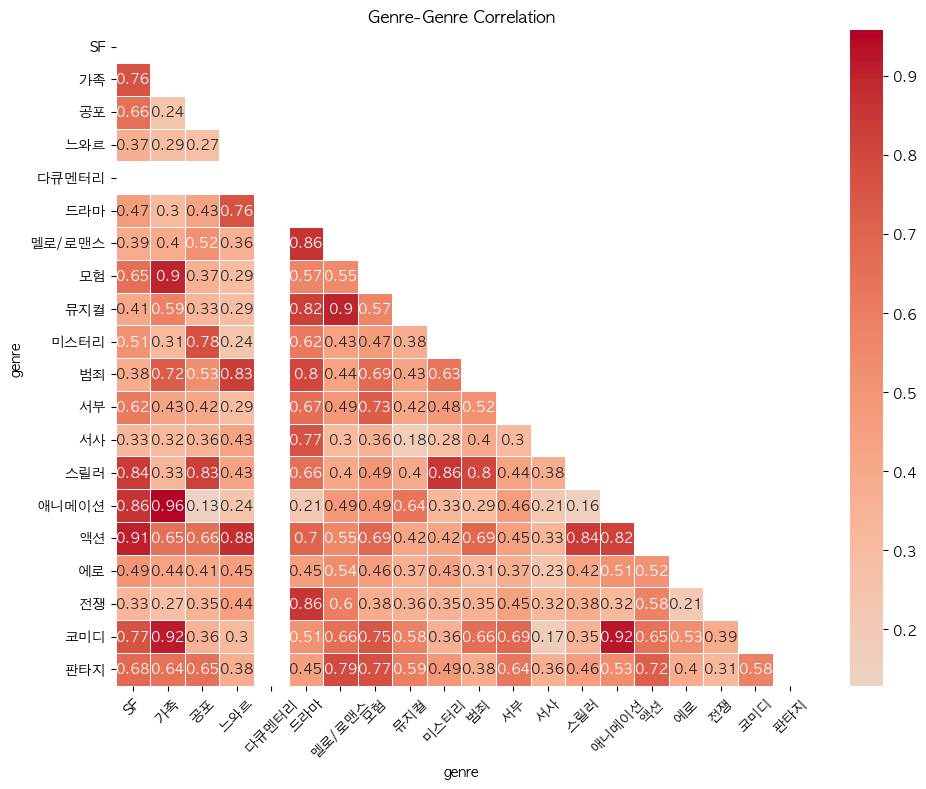

In [34]:
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(
    genre_correlation, 
    mask=mask,
    cmap='coolwarm', 
    center=0, 
    annot=True,
    linewidths=.5
)
plt.title("Genre-Genre Correlation")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
# mask = np.triu(np.ones_like(genre_correlation_kendall, dtype=bool))

# plt.figure(figsize=(10,8))
# sns.heatmap(
#     genre_correlation_kendall, 
#     mask=mask,
#     cmap='coolwarm', 
#     center=0, 
#     annot=True,
#     linewidths=.5
# )
# plt.title("Genre-Genre Correlation (Kendall-tau)")
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [36]:
# mask = np.triu(np.ones_like(genre_correlation_spearman, dtype=bool))

# plt.figure(figsize=(10,8))
# sns.heatmap(
#     genre_correlation_spearman, 
#     mask=mask,
#     cmap='coolwarm', 
#     center=0, 
#     annot=True,
#     linewidths=.5
# )
# plt.title("Genre-Genre Correlation (Spearman)")
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

## 결론

- 사용자들은 아래의 장르 쌍들에 속하는 영화를 같이 시청 (평가) 하는 경향이 있는것으로 보인다. (양의 상관관계가 존재함)
  1. 애니메이션, 가족 (0.96)
  2. 코미디, 가족 (0.92)
  3. 코미디, 애니메이션 (0.92)
  4. 액션, SF (0.91)
  5. 모험, 가족 (0.9)
  6. 뮤지컬, 멜로/로맨스 (0.9)
  7. 액션, 느와르 (0.88)
  8. 스릴러, 미스터리 (0.86)
  9. 전쟁, 드라마 (0.86)
  10. 멜로/로맨스, 드라마 (0.86)
  11. 애니메이션, SF (0.86)
- 하지만, 어떻게 보면 당연한 결과이기도 하다. 예를 들어:
  - 애니메이션과 가족이라면, 애니메이션을 좋아하는 아이들이 많이 시청하는 가족 영화가 많을 것이다.
  - 일반적으로 멜로/로맨스 장르의 영화는 대부분 드라마 장르에 속한다.
- 따라서, 이러한 결과는 영화 장르간의 상관 관계를 확인하고 사용자에게 영화를 추천하는데 도움이 될 수 있지만, 절대적으로 의존하기에는 무리가 있다.